# Japanese Equity Data - Feature Engineering

## Imports & Settings

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set_style('white')

In [6]:
idx = pd.IndexSlice

## Get Data

### Stooq Japanese Equity data 2014-2019

In [50]:
# DATA_DIR = Path('..', 'data')

In [51]:
# prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'stooq/jp/tse/stocks/prices')
#           .loc[idx[:, '2010': '2019'], :]
#           .loc[lambda df: ~df.index.duplicated(), :])

In [7]:
# prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7491767 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7491767 non-null  float64
 1   high    7491767 non-null  float64
 2   low     7491767 non-null  float64
 3   close   7491767 non-null  float64
 4   volume  7491767 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 314.7+ MB


In [39]:
df = pd.read_csv("./minute/AAPL.csv")
df['ticker'] = 'AAPL'
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date', 'ticker'])
df = df.reorder_levels(['ticker', 'date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2610 entries, ('AAPL', Timestamp('2020-12-07 09:30:00-0500', tz='pytz.FixedOffset(-300)')) to ('AAPL', Timestamp('2020-12-15 14:05:00-0500', tz='pytz.FixedOffset(-300)'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2610 non-null   float64
 1   high    2610 non-null   float64
 2   low     2610 non-null   float64
 3   close   2610 non-null   float64
 4   volume  2610 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 194.7+ KB


In [32]:
df.head()

open        high         low  \
ticker date                                                            
AAPL   2020-12-07 09:30:00-05:00  369.019989  369.109985  368.920013   
       2020-12-07 09:31:00-05:00  368.929993  369.170013  368.899994   
       2020-12-07 09:32:00-05:00  369.049988  369.070007  369.029999   
       2020-12-07 09:34:00-05:00  369.160004  369.209900  369.019989   
       2020-12-07 09:35:00-05:00  369.040008  369.089996  369.040008   

                                       close   volume  
ticker date                                            
AAPL   2020-12-07 09:30:00-05:00  368.929993  1273791  
       2020-12-07 09:31:00-05:00  369.040008   261070  
       2020-12-07 09:32:00-05:00  369.040008    34989  
       2020-12-07 09:34:00-05:00  369.059998   438059  
       2020-12-07 09:35:00-05:00  369.049988     4296

In [40]:
df.dtypes

open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object

In [44]:
DATA_STORE = Path('assets.h5')


print(df.info(null_counts=True))


# Identify the problematic index level(s) and convert them to object
for i, level in enumerate(df.index.levels):
    if pd.api.types.is_extension_array_dtype(level):
        df.index = df.index.set_levels(level.astype('object'), level=i)

# Now try saving again
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/prices', df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2610 entries, ('AAPL', Timestamp('2020-12-07 09:30:00-0500', tz='pytz.FixedOffset(-300)')) to ('AAPL', Timestamp('2020-12-15 14:05:00-0500', tz='pytz.FixedOffset(-300)'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2610 non-null   float64
 1   high    2610 non-null   float64
 2   low     2610 non-null   float64
 3   close   2610 non-null   float64
 4   volume  2610 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 194.7+ KB
None


In [52]:
prices = (pd.read_hdf('assets.h5', 'quandl/wiki/prices')
          .loc[idx[:, '2020-12-07': '2020-12-15'], :]
          .loc[lambda df: ~df.index.duplicated(), :])

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2610 entries, ('AAPL', Timestamp('2020-12-07 09:30:00-0500', tz='pytz.FixedOffset(-300)')) to ('AAPL', Timestamp('2020-12-15 14:05:00-0500', tz='pytz.FixedOffset(-300)'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2610 non-null   float64
 1   high    2610 non-null   float64
 2   low     2610 non-null   float64
 3   close   2610 non-null   float64
 4   volume  2610 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 194.7+ KB


In [53]:
before = len(prices.index.unique('ticker').unique())

### Remove symbols with missing values

In [54]:
prices = (prices.unstack('ticker')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1)
        .stack('ticker')
        .swaplevel())
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2610 entries, ('AAPL', Timestamp('2020-12-07 09:30:00-0500', tz='pytz.FixedOffset(-300)')) to ('AAPL', Timestamp('2020-12-15 14:05:00-0500', tz='pytz.FixedOffset(-300)'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2610 non-null   float64
 1   high    2610 non-null   float64
 2   low     2610 non-null   float64
 3   close   2610 non-null   float64
 4   volume  2610 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 194.7+ KB


In [55]:
after = len(prices.index.unique('ticker').unique())
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 1 after: 1


### Keep most traded symbols

In [75]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('ticker').median().nlargest(1000).index.tolist()

In [76]:
prices = prices.loc[idx[keep, :], :]
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2610 entries, ('AAPL', Timestamp('2020-12-07 09:30:00-0500', tz='pytz.FixedOffset(-300)')) to ('AAPL', Timestamp('2020-12-15 14:05:00-0500', tz='pytz.FixedOffset(-300)'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2610 non-null   float64
 1   high    2610 non-null   float64
 2   low     2610 non-null   float64
 3   close   2610 non-null   float64
 4   volume  2610 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 194.7+ KB


## Feature Engineering

### Compute period returns

In [77]:
intervals = [1, 5, 10, 21, 63]

In [83]:
returns = []
by_ticker = prices.groupby(level='ticker').close
for t in intervals:
    returns.append(by_ticker.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

In [84]:
returns.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2610 entries, ('AAPL', Timestamp('2020-12-07 09:30:00-0500', tz='pytz.FixedOffset(-300)')) to ('AAPL', Timestamp('2020-12-15 14:05:00-0500', tz='pytz.FixedOffset(-300)'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_1   2609 non-null   float64
 1   ret_5   2605 non-null   float64
 2   ret_10  2600 non-null   float64
 3   ret_21  2589 non-null   float64
 4   ret_63  2547 non-null   float64
dtypes: float64(5)
memory usage: 194.7+ KB


### Remove outliers

In [85]:
max_ret_by_sym = returns.groupby(level='ticker').max()

In [86]:
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.007761,0.007679,0.008463,0.009874,0.010373
std,NaN,NaN,NaN,NaN,NaN
min,0.007761,0.007679,0.008463,0.009874,0.010373
50%,0.007761,0.007679,0.008463,0.009874,0.010373
90%,0.007761,0.007679,0.008463,0.009874,0.010373
95%,0.007761,0.007679,0.008463,0.009874,0.010373
97.5%,0.007761,0.007679,0.008463,0.009874,0.010373
99%,0.007761,0.007679,0.008463,0.009874,0.010373
99.5%,0.007761,0.007679,0.008463,0.009874,0.010373


In [87]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist()) 

In [88]:
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

0

In [89]:
prices = prices.drop(to_drop, level='ticker')
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2610 entries, ('AAPL', Timestamp('2020-12-07 09:30:00-0500', tz='pytz.FixedOffset(-300)')) to ('AAPL', Timestamp('2020-12-15 14:05:00-0500', tz='pytz.FixedOffset(-300)'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2610 non-null   float64
 1   high    2610 non-null   float64
 2   low     2610 non-null   float64
 3   close   2610 non-null   float64
 4   volume  2610 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 194.7+ KB


### Calculate relative return percentiles

In [92]:
prices

open        high         low  \
ticker date                                                            
AAPL   2020-12-07 09:30:00-05:00  369.019989  369.109985  368.920013   
       2020-12-07 09:31:00-05:00  368.929993  369.170013  368.899994   
       2020-12-07 09:32:00-05:00  369.049988  369.070007  369.029999   
       2020-12-07 09:34:00-05:00  369.160004  369.209900  369.019989   
       2020-12-07 09:35:00-05:00  369.040008  369.089996  369.040008   
...                                      ...         ...         ...   
       2020-12-15 14:01:00-05:00  369.089996  369.089996  369.001099   
       2020-12-15 14:02:00-05:00  369.040008  369.040008  368.980011   
       2020-12-15 14:03:00-05:00  369.010010  369.019989  368.970001   
       2020-12-15 14:04:00-05:00  369.049988  369.100006  368.980011   
       2020-12-15 14:05:00-05:00  369.079987  369.079987  369.079987   

                                       close   volume  
ticker date                                            
AAPL   2020-12-07 09:30:00-05:00  368.929993  1273791  
       2020-12-07 09:31:00-05:00  369.040008   261070  
       2020-12-07 09:32:00-05:00  369.040008    34989  
       2020-12-07 09:34:00-05:00  369.059998   438059  
       2020-12-07 09:35:00-05:00  369.049988     4296  
...                                      ...      ...  
       2020-12-15 14:01:00-05:00  369.045013    58115  
       2020-12-15 14:02:00-05:00  368.994995    52999  
       2020-12-15 14:03:00-05:00  369.010010    80191  
       2020-12-15 14:04:00-05:00  369.011108    82337  
       2020-12-15 14:05:00-05:00  369.079987        0  

[2610 rows x 5 columns]

In [93]:
returns = []
by_sym = prices.groupby(level='ticker').close
for t in intervals:
    ret = by_sym.pct_change(t).fillna(0)
    rel_perc = (ret.groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

### Technical Indicators

#### Percentage Price Oscillator

In [96]:
ppo = prices.groupby(level='ticker').close.apply(talib.PPO).to_frame('PPO')

#### Normalized Average True Range

In [115]:
natr = prices.groupby(level='ticker', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).T

natr.columns  = ["NATR"]
natr

NATR
ticker date                               
AAPL   2020-12-07 09:30:00-05:00       NaN
       2020-12-07 09:31:00-05:00       NaN
       2020-12-07 09:32:00-05:00       NaN
       2020-12-07 09:34:00-05:00       NaN
       2020-12-07 09:35:00-05:00       NaN
...                                    ...
       2020-12-15 14:01:00-05:00  0.028146
       2020-12-15 14:02:00-05:00  0.027398
       2020-12-15 14:03:00-05:00  0.026407
       2020-12-15 14:04:00-05:00  0.026844
       2020-12-15 14:05:00-05:00  0.026255

[2610 rows x 1 columns]

#### Relative Strength Indicator

In [107]:
rsi = prices.groupby(level='ticker').close.apply(talib.RSI).to_frame('RSI')

rsi

RSI
ticker date                                
AAPL   2020-12-07 09:30:00-05:00        NaN
       2020-12-07 09:31:00-05:00        NaN
       2020-12-07 09:32:00-05:00        NaN
       2020-12-07 09:34:00-05:00        NaN
       2020-12-07 09:35:00-05:00        NaN
...                                     ...
       2020-12-15 14:01:00-05:00  55.960982
       2020-12-15 14:02:00-05:00  52.241696
       2020-12-15 14:03:00-05:00  53.246227
       2020-12-15 14:04:00-05:00  53.323588
       2020-12-15 14:05:00-05:00  58.014225

[2610 rows x 1 columns]

#### Bollinger Bands

In [116]:
def get_bollinger(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})

In [117]:
bbands = prices.groupby(level='ticker').close.apply(get_bollinger)

### Combine Features

In [118]:
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)

In [119]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)

In [120]:
data.bbu.corr(data.bbl, method='spearman')

-0.19627901962054617

### Plot Indicators for randomly sample ticker

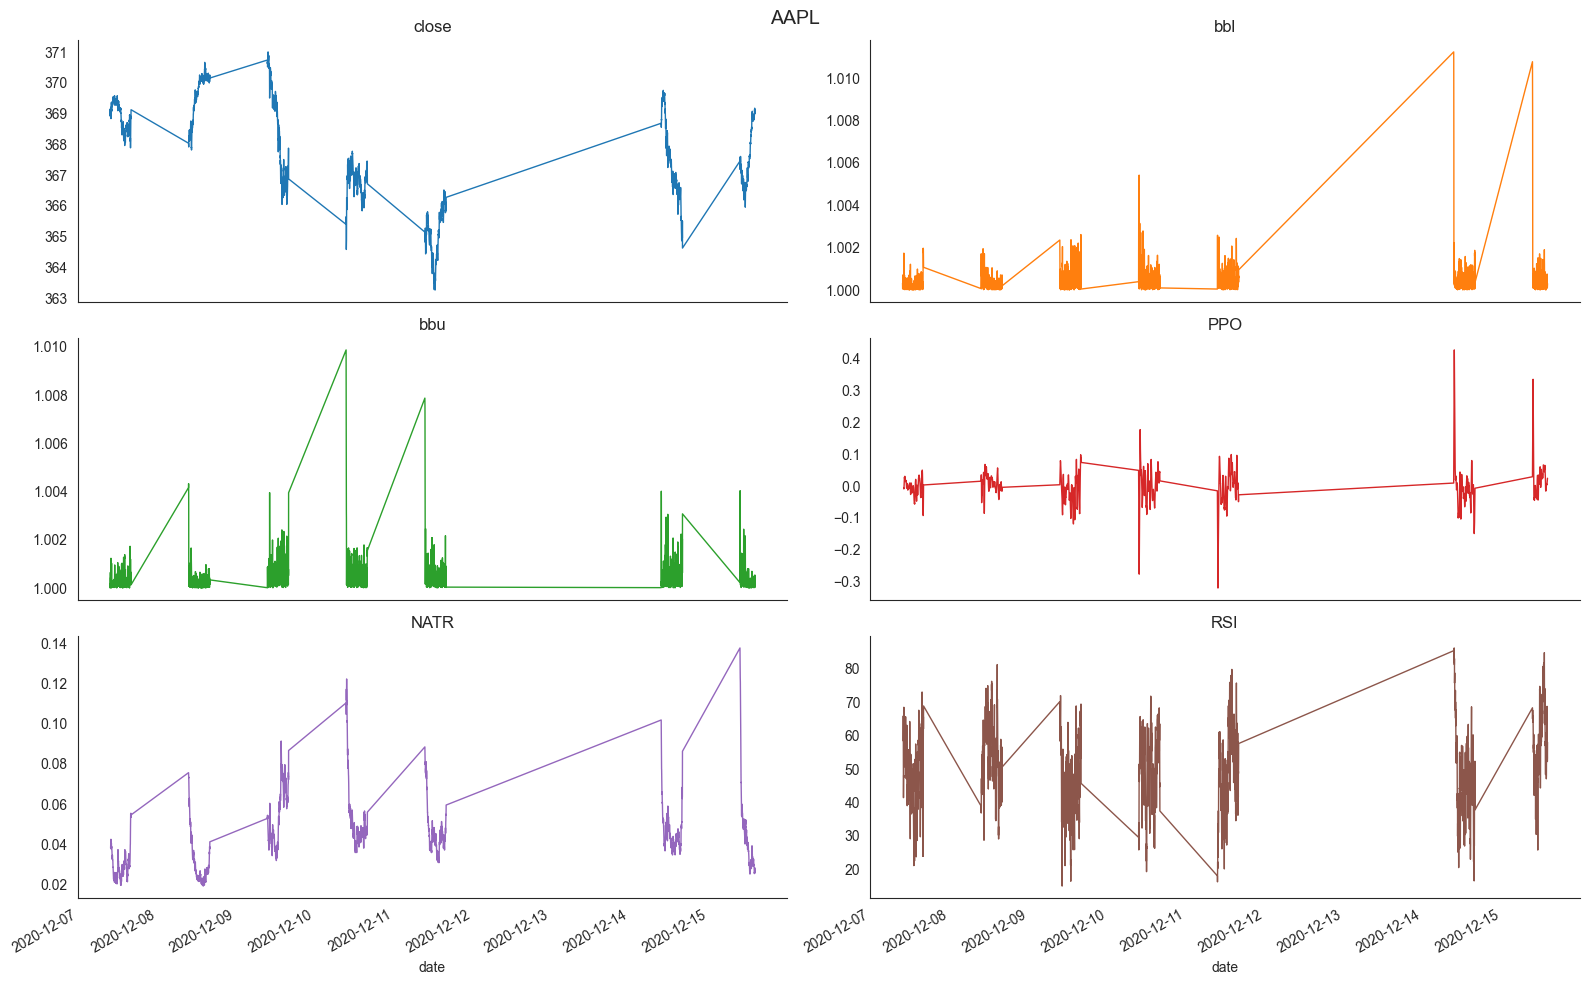

In [121]:
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [122]:
data = data.drop(prices.columns, axis=1)

### Create time period indicators

In [123]:
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

## Compute forward returns

In [124]:
outcomes = []
by_ticker = data.groupby('ticker')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_ticker[f'ret_{t}'].shift(-t)

In [125]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2610 entries, ('AAPL', Timestamp('2020-12-07 09:30:00-0500', tz='pytz.FixedOffset(-300)')) to ('AAPL', Timestamp('2020-12-15 14:05:00-0500', tz='pytz.FixedOffset(-300)'))
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ret_1            2610 non-null   float64
 1   ret_rel_perc_1   0 non-null      float64
 2   ret_5            2610 non-null   float64
 3   ret_rel_perc_5   0 non-null      float64
 4   ret_10           2610 non-null   float64
 5   ret_rel_perc_10  0 non-null      float64
 6   ret_21           2610 non-null   float64
 7   ret_rel_perc_21  0 non-null      float64
 8   ret_63           2610 non-null   float64
 9   ret_rel_perc_63  0 non-null      float64
 10  PPO              2585 non-null   float64
 11  NATR             2596 non-null   float64
 12  RSI              2596 non-null   float64
 13  bbl              2606 non-null   float64
 14  bbu  

In [127]:
# Identify the problematic index level(s) and convert them to object
for i, level in enumerate(data.index.levels):
    if pd.api.types.is_extension_array_dtype(level):
        data.index = data.index.set_levels(level.astype('object'), level=i)

data.to_hdf('data.h5', 'quandl/wiki/prices')